In [3]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

In [4]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = True

plt.rcParams['figure.figsize'] = (8.0, 8.0)

# All mixture of expert model

In [5]:
class TorchDataset(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TorchDataset, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [ ]:
class HyperModelNN(nn.Module):
    def __init__(self, input_dim = 20, hidden_dim = 10, output_dim = 10, device = 'cpu'):
        super(HyperModelNN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001)
        
        self.to(device)
        
    def forward(self, input):
        out = input
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def E_step(self, X, Y, Z, HyperParameters):
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        dataset = TorchDataset(X, Z, device = self.device)
        
        for _ in range(100):
            train_generator = DataLoader(dataset = dataset, batch_size = 16, shuffle=True)
            for it, (batch_of_x, batch_of_z) in enumerate(train_generator):
                self.zero_grad()
                loss = -(torch.nn.functional.log_softmax(self.forward(batch_of_x), dim = -1)*batch_of_z).sum()
                loss.backward()
                self.optimizer.step()
        pass


In [ ]:
class EachModelLinear_diagonal_prior:
    def __init__(self, input_dim = 20, device = 'cpu', a = None, w = None):
        self.input_dim = input_dim
        self.device = device
        
        self.a = a
        self.w_0 = w
            
        self.W = torch.randn(input_dim, 1, device = self.device)
        
        if w is not None:
            self.W = w.detach()
        
        self.B = torch.eye(input_dim, device = self.device)

        
    def forward(self, input):
        return input@self.W
    
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            temp2 = -2*Y*(X@self.W)
            temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
            return ((temp1 + temp2 + temp3)*Z).mean().detach()
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        temp2 = -2*Y*(X@self.W)
        temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
        return (-0.5*beta*(temp1 + temp2 + temp3) + 0.5*math.log(beta/(2*math.pi))).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        if self.a is None:
            self.B = torch.inverse(((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])
            self.W.data = (self.B@second).view_as(self.W).detach()
        else:
            self.B = torch.inverse(torch.diag(1/self.a) + beta*((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])       
            if self.w_0 is None:
                self.W.data = (beta*(self.B@second)).view_as(self.W).detach()
            else:
                self.W.data = (self.B@(beta*second + torch.diag(1/self.a)@self.w_0)).view_as(self.W).detach()
        
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        if self.a is not None:
            if self.w_0 is not None:
                self.a = torch.diagonal(self.B+self.W@self.W.transpose(0,1) - self.w_0@self.W.transpose(0,1) - self.W@self.w_0.transpose(0,1) + self.w_0@self.w_0.transpose(0,1)).detach()
            else:
                self.a = torch.diagonal(self.B+self.W@self.W.transpose(0,1)).detach()
        if self.w_0 is not None:
            self.w_0 = (self.W).detach()

        return

In [537]:
class EachModelLinear:
    def __init__(self, input_dim = 20, device = 'cpu', A = None, w = None):
        self.input_dim = input_dim
        self.device = device
        
        self.A = A
        self.w_0 = w.clone()
            
        self.W = torch.randn(input_dim, 1, device = self.device)
        
        if w is not None:
            self.W.data = w.data.clone() + (1e-5)*torch.randn(input_dim, 1, device = self.device)
        
        self.B = torch.eye(input_dim, device = self.device)

        
    def forward(self, input):
        return input@self.W
    
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            temp2 = -2*Y*(X@self.W)
            temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
            return ((temp1 + temp2 + temp3)*Z).mean().detach()
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        temp2 = -2*Y*(X@self.W)
        temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
        return (-0.5*beta*(temp1 + temp2 + temp3) + 0.5*np.log(beta/(2*np.pi))).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        if self.A is None:
            self.B = torch.inverse(((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])
            self.W.data = (self.B@second).view_as(self.W).detach()
        else:
            self.B = torch.inverse(torch.inverse(self.A) + beta*((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0).view([-1, 1])       
            if self.w_0 is None:
                self.W.data = (beta*(self.B@second)).view_as(self.W).detach()
            else:
                self.W.data = (self.B@(beta*second + torch.inverse(self.A)@self.w_0)).view_as(self.W).detach()
        
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        if self.A is not None:
            if self.w_0 is not None:
                self.A= (self.B+self.W@self.W.transpose(0,1) - self.w_0@self.W.transpose(0,1) - self.W@self.w_0.transpose(0,1) + self.w_0@self.w_0.transpose(0,1)).detach()
            else:
                self.A = (self.B+self.W@self.W.transpose(0,1)).detach()
        
        if self.w_0 is not None:
            self.w_0.data[:3,:] = self.W.data[:3,:].clone()

        return



In [298]:
class RegularizeModel:
    def __init__(self, ListOfModels = None, device = 'cpu'):
                
        if ListOfModels is None:
            self.ListOfModels = []
        else:
            self.ListOfModels = ListOfModels

        
    def forward(self, input):
        pass
    
    def __call__(self, input):
        pass

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        pass

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        alpha = 1./(HyperParameters['alpha']+1e-30)
        K = len(self.ListOfModels)
        
        ListOfNewW0 = []
        
        for k in range(K):
            if self.ListOfModels[k].w_0 is not None:
                temp1 = torch.inverse(torch.inverse(self.ListOfModels[k].A) - alpha*(K)*torch.diag(torch.ones_like(self.ListOfModels[k].w_0.view(-1))))
                temp2 = torch.inverse(self.ListOfModels[k].A)@self.ListOfModels[k].W - alpha*torch.cat([self.ListOfModels[t].w_0  for t in range(K) if t==t], dim = 1).sum(dim=1).view([-1,1])
                ListOfNewW0.append((temp1@temp2).detach().data[:2,:])
#                 ListOfNewW0.append(torch.cat([self.ListOfModels[t].w_0  for t in range(K)], dim = 1).mean(dim=1).view([-1,1]).detach().data[:2,:])
            else:
                ListOfNewW0.append(None)
                
        for k in range(K):
            if self.ListOfModels[k].w_0 is not None:
                self.ListOfModels[k].w_0.data[:2, :] = ListOfNewW0[k]
        return




In [299]:
class MixtureExpert:
    def __init__(self, input_dim = 10, K = 2, HyperParameters = {'beta': 1, 'alpha': 1}, HyperModel = None, ListOfModels = None, ListOfRegularizeModel = None, device = 'cpu'):
        """
        It's necessary! The Hyper Parameter should be additive to models.
        """
        
        self.K = K
        self.n = input_dim
        self.device = device
        
        self.HyperParameters = HyperParameters
        
        if HyperModel is None:
            self.HyperModel = HyperModelNN(input_dim = input_dim, hidden_dim = 10, output_dim = K, device = device)
        else:
            self.HyperModel = HyperModel
            
        if ListOfRegularizeModel is None:
            self.ListOfRegularizeModel = []
        else:
            self.ListOfRegularizeModel = ListOfRegularizeModel
            
        if ListOfModels is None:
            self.ListOfModels = [EachModelLinear(input_dim = input_dim, device = device) for _ in range(K)]
        else:
            self.ListOfModels = ListOfModels
        
        self.pZ = None
        return
        
    def E_step(self, X, Y):
# Optimize Z
        temp1 = torch.nn.functional.log_softmax(self.HyperModel(X), dim = -1)
        temp2 = torch.cat([self.ListOfModels[k].LogLikeLihoodExpectation(X, Y, self.HyperParameters) for k in range(self.K)], dim = 1)
        self.pZ = torch.nn.functional.softmax(temp1 + temp2, dim=-1).detach()
    
# Optimize each model
        for k in range(self.K):
            self.ListOfModels[k].E_step(X, Y, self.pZ[:,k].view([-1, 1]), self.HyperParameters)

# Do reqularization
        for k in range(len(self.ListOfRegularizeModel)):
            self.ListOfRegularizeModel[k].E_step(X, Y, self.pZ, self.HyperParameters)

# Optimize HyperModel
        self.HyperModel.E_step(X, Y, self.pZ, self.HyperParameters)
        return
        
    def M_step(self, X, Y):
# Optimize EachModel
        for k in range(self.K):
            self.ListOfModels[k].M_step(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters)
            
# Optimize HyperParameters
        for Parameter in self.HyperParameters:
            temp = None
            for k in range(self.K):
                ret = self.ListOfModels[k].OptimizeHyperParameters(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters, Parameter)
                if ret is not None:
                    if temp is None:
                        temp = 0
                    temp += ret
            
            if temp is not None:
                self.HyperParameters[Parameter] = temp.detach()
            
# Optimize HyperModel
        self.HyperModel.M_step(X, Y, self.pZ, self.HyperParameters)
    
# Do reqularization
        for k in range(len(self.ListOfRegularizeModel)):
            self.ListOfRegularizeModel[k].M_step(X, Y, self.pZ, self.HyperParameters)

        return
                
    def fit(self, X = None, Y = None, epoch = 10, progress = None):
        """
        X has a shape [N x n]
        Y has a shape [n x p]
        """
        if X is None:
            return None
        if y is None:
            return None
        
        iterations = range(epoch)
        
        if progress is not None:
            iterations = progress(iterations)
        
        for _ in iterations:
            self.E_step(X, Y)
            self.M_step(X, Y)
            
        return
    
    def predict(self, X):
        """
        X has a shape [N x n]
        """
        pi = torch.nn.functional.softmax(self.HyperModel(X), dim = -1).detach()
        answ = torch.cat([self.ListOfModels[k](X) for k in range(self.K)], dim = 1).detach()
        
        return (answ*pi).sum(dim = -1).data.numpy()
    

# Experiment

In [155]:
N = 5000
n = 3
r1 = 0.5
r2 = 1.5
phi = np.linspace(0, 2*np.pi, N)

x0 = 0
y0 = 0

x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0])
# x = np.hstack([r1*np.sin(phi) + x0, r2*np.sin(phi) + x0, 4*(np.random.rand(500)-0.5) + x0])
x += 0.05*np.random.randn(x.shape[0])
y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0])
# y = np.hstack([r1*np.cos(phi) + y0, r2*np.cos(phi) + y0, 4*(np.random.rand(500)-0.5) + y0])
y += 0.05*np.random.randn(y.shape[0])



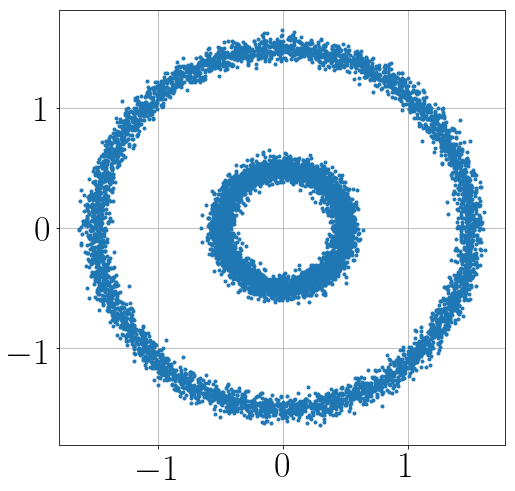

In [10]:
plt.plot(x, y, '.')

plt.grid()

plt.show()

In [11]:
x = scale(x)
y = scale(y)

x, y = shuffle(x, y)

x = x[:100]
y = y[:100]

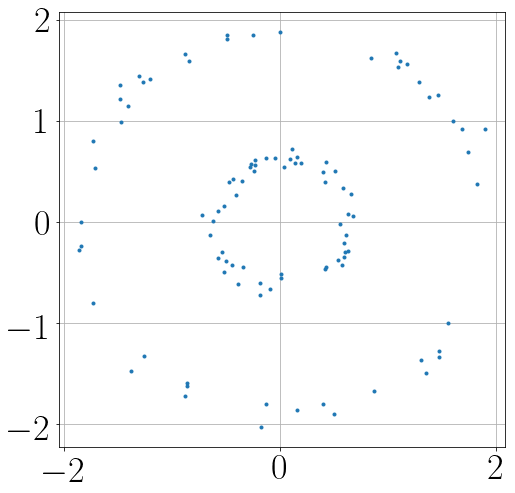

In [12]:
plt.plot(x, y, '.')

plt.grid()

plt.show()

In [13]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([100, 3]), torch.Size([100, 1]))

In [16]:
K = 2
LIST_A = [torch.Tensor([1, 1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0], [0], [1]]), torch.Tensor([[0], [0], [2]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

# K += 1
# LoM.append(RegularizeModel(ListOfModels = LoM))

HypPar = {'beta': 1, 'alpha': 0.00}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)




In [17]:
%%time
model.fit(X_tr, Y_tr, 10, progress = tqdm)


CPU times: user 2.9 s, sys: 111 ms, total: 3.01 s
Wall time: 3.07 s


In [18]:
model.HyperParameters

{'beta': tensor(0.0343), 'alpha': 0.0}

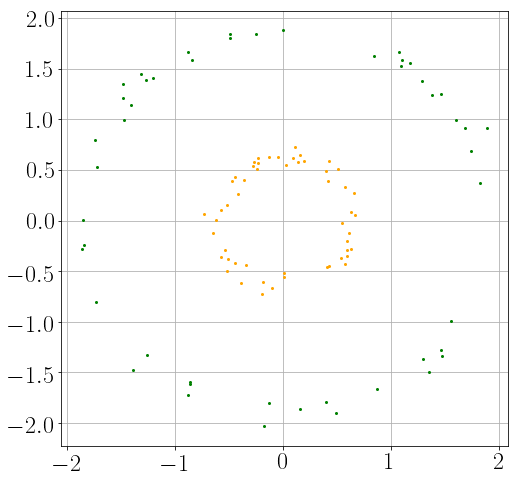

In [19]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [20]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[ 0.00922978, -0.00549929,  0.40593162],
       [ 0.05127767, -0.01194385,  3.6043916 ]], dtype=float32)

In [21]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[ 0.00461489, -0.00274964,  0.6371503 ],
       [ 0.02563883, -0.00597192,  1.8987061 ]], dtype=float32)

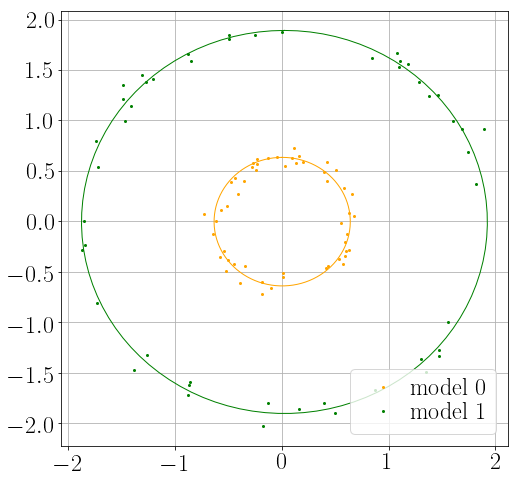

In [22]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

# plt.savefig('results/full_infomative.pdf', )

plt.show()

# Picture Real

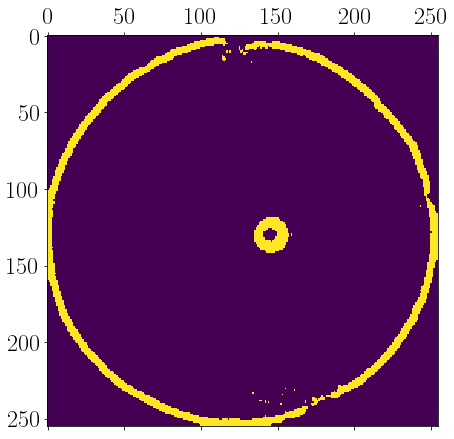

In [42]:
image = Image.open('Picture/1_mask.jpg').convert('L')

image = Image.fromarray((255*(np.array(image) > 125)).astype(np.uint8))

mask_1 = Image.open('Picture/1_mask.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

plt.matshow(mask_1)

In [24]:
x = np.array(np.where(np.array(image) > 0)[1], dtype = np.float)
y = np.array(image.size[0]-np.where(np.array(image) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y)

x = x[:300]
y = y[:300]

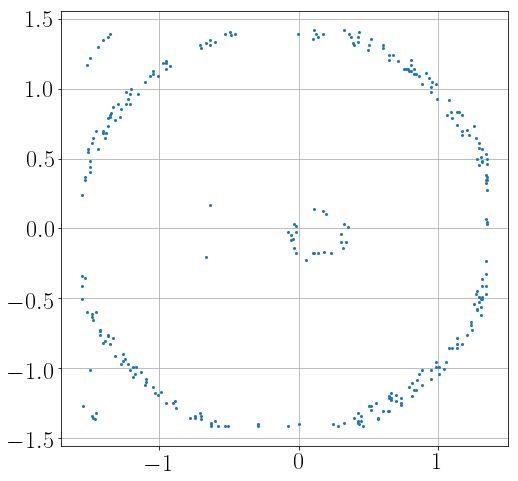

In [28]:
plt.plot(x, y, '.')

plt.grid()

In [29]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

In [44]:
K = 2
LIST_A = [torch.Tensor([0.01, 0.01, 0.01]) for _ in range(K)]
LIST_w = [torch.Tensor([[1], [0.5], [0.1]]), torch.Tensor([[0.1], [0.3], [2]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

# K += 1
# LoM.append(NoiseModelLinear(input_dim = n))

HypPar = {'beta': 1, 'alpha': 0.0}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)




In [55]:
%%time
model.fit(X_tr, Y_tr, 10, progress = tqdm)



CPU times: user 7.54 s, sys: 245 ms, total: 7.78 s
Wall time: 7.91 s


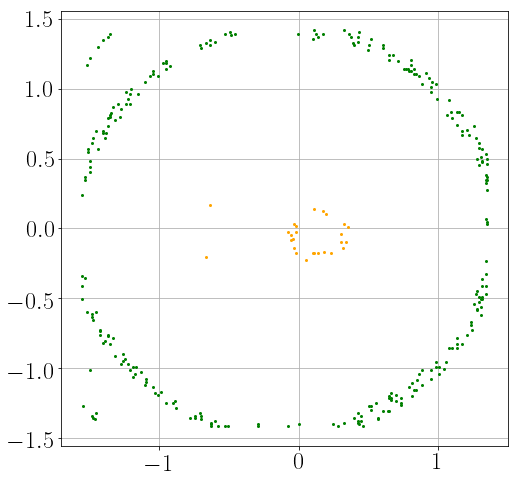

In [56]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [57]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-0.23530006,  0.16041923,  0.05639981],
       [-0.1899085 , -0.1831572 ,  2.2003396 ]], dtype=float32)

In [58]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[-0.11765003,  0.08020961,  0.27690238],
       [-0.09495425, -0.0915786 ,  1.4892087 ]], dtype=float32)

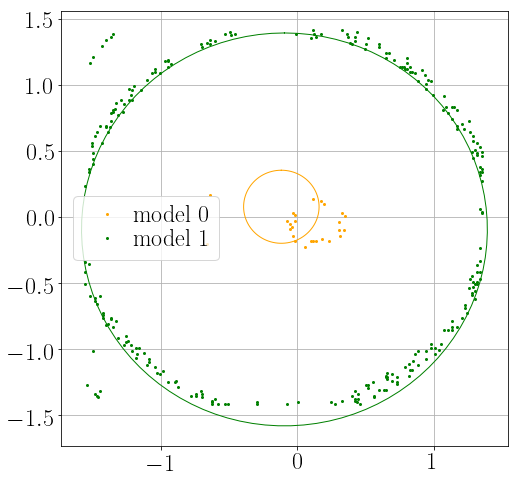

In [59]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

# plt.savefig('results/full_infomative.pdf', )

plt.show()

# Picture in Experiment with real Data

In [300]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [301]:
image = Image.open('Picture/1.tif')

mask_1 = Image.open('Picture/1_mask_2.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

In [302]:
x = np.array(np.where(np.array(mask_1) > 0)[1], dtype = np.float)
y = np.array(mask_1.size[0]-np.where(np.array(mask_1) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y, random_state = 0)

x = x[:200]
y = y[:200]

In [303]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 3]), torch.Size([200, 1]))

In [495]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    return CIRCLE, idx

In [587]:
K = 2
n = 3
LIST_A = [torch.Tensor([0.01, 0.01, 0.01]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.0], [0.0], [0.1]]), torch.Tensor([[0.0], [0.0], [1]])]


LoM = []
for k in range(K):
#     LoM.append(EachModelLinear(input_dim = n, device = device))
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k]))

# K += 1
# LoM.append(NoiseModelLinear(input_dim = n))

HypPar = {'beta': 1, 'alpha': 1e-5}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

# model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)
model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)




In [588]:
List_of_step = []
EPOCH = 0

In [603]:
%%time
count = 10
model.fit(X_tr, Y_tr, count, progress = tqdm)
EPOCH+=count

CPU times: user 5.14 s, sys: 169 ms, total: 5.31 s
Wall time: 5.39 s


In [604]:
List_of_step.append((extract_picture(model), EPOCH))

In [605]:
len(List_of_step), EPOCH

(3, 30)

In [606]:
np.array([m.w_0.data.numpy().reshape(-1) for m in model.ListOfModels])

array([[-1.1843224 ,  0.9792061 ,  0.21977308],
       [-0.26437366, -0.02464974,  2.2173374 ]], dtype=float32)

In [607]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[-1.1843224 ,  0.9792061 ,  0.21977308],
       [-0.26437366, -0.02464974,  2.2173374 ]], dtype=float32)

In [608]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[-0.5921612 ,  0.48960304,  0.9000773 ],
       [-0.13218683, -0.01232487,  1.4949791 ]], dtype=float32)

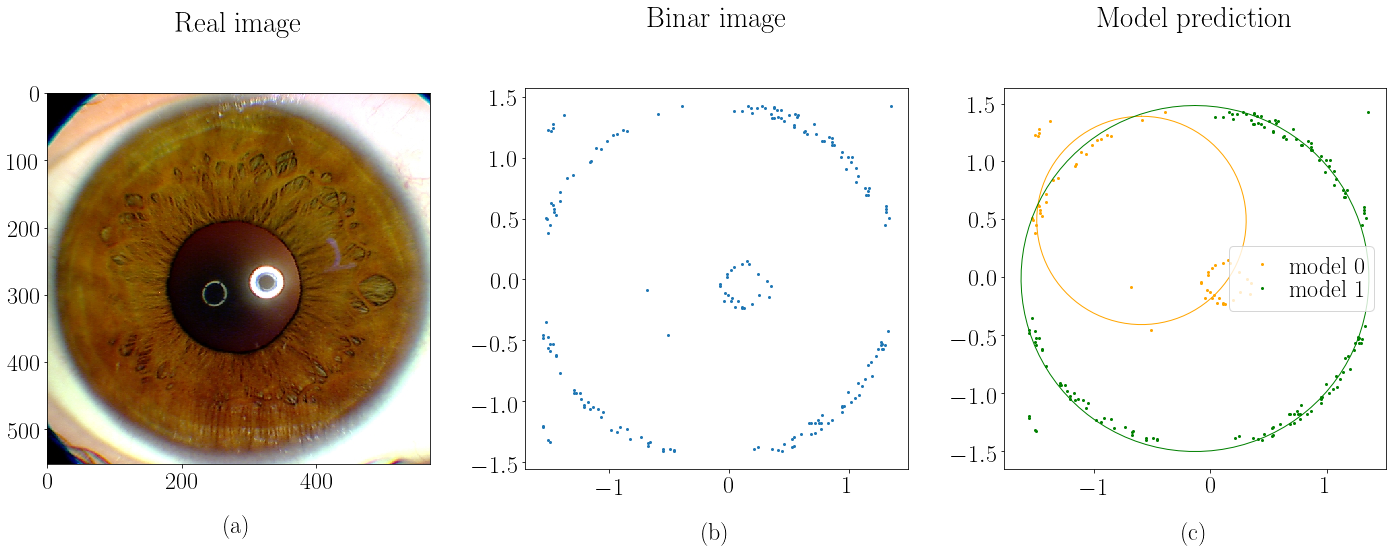

In [612]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 7.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']


fig = plt.figure();

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax = [] 
for k in range(3):
    ax.append(fig.add_subplot(gs[k]))
    
cols = ['Real image', 'Binar image', 'Model prediction']

TITLE = ['(a)', '(b)', '(c)']

for k in range(3):
    ax[k].set_title(TITLE[k], y=-0.2)

# Real image
k = 0
ax[k].imshow(image)
ax[k].annotate(cols[k], xy=(0.5, 1.1), xytext=(0, 24),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

# mask with iris circle
k = 1
ax[k].plot(x, y, '.')
ax[k].annotate(cols[k], xy=(0.5, 1.1), xytext=(0, 24),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

# model prediction
idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)
colors = ['orange', 'green', 'red', 'yellow', 'blue']

k = 2

for i in np.unique(idx):
    _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])
    
ax[k].legend(loc = 'best')

# ax[k].plot(x, y, '.')
ax[k].annotate(cols[k], xy=(0.5, 1.1), xytext=(0, 24),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

# #------___1___------
# for k in range(len(List_of_Data)):
#     x, y = List_of_Data[k]
    
#     ax1[k].annotate(cols[k], xy=(0.5, 1), xytext=(0, 24),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size='large', ha='center', va='baseline')

#     ax1[k].set_xlabel('$x$')
#     ax1[k].set_ylabel('$y$')
    
#     _ = ax1[k].plot(x, y, '.', color = colors[0])
#     ax1[k].set_title(TITLE[k], y=-0.24)
        


plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./result/experiment_real_prior.pdf', bbox_inches='tight')

plt.show()

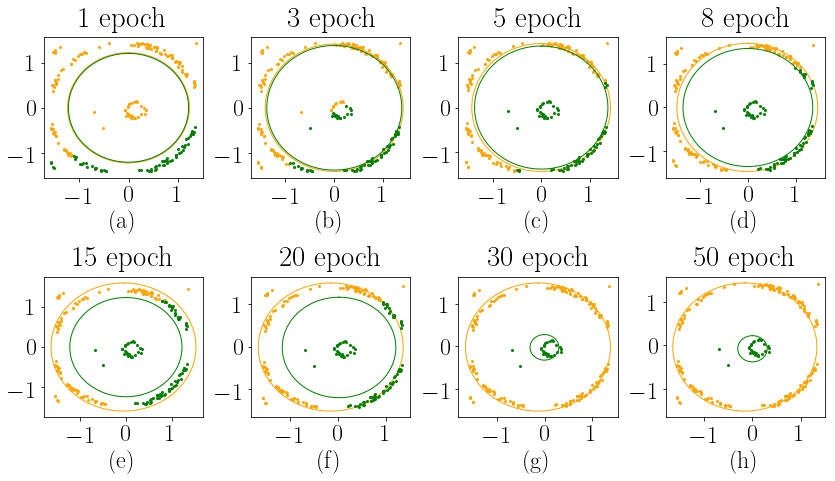

In [494]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (14.0, 7.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']


fig = plt.figure();

gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1])

ax = [] 
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

TITLE = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

    ax[k].legend(loc = 'best')
    ax[k].set_title(TITLE[k], y=-0.4)

    # ax[k].plot(x, y, '.')
    ax[k].annotate(str(epoch) + ' epoch', xy=(0.5, 0.9), xytext=(0, 24),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.savefig('./result/experiment_real_progress.pdf', bbox_inches='tight')

plt.show()